# Baseline ML Model

In [24]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.linear_model import LinearRegression, ElasticNet, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from lightgbm import LGBMRegressor

import optuna

In [3]:
with open('../data/processed/dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [5]:
dataset.keys()

dict_keys(['X_train', 'y_train', 'X_val', 'y_val', 'X_test', 'y_test', 'X_train_store_category_le', 'X_val_store_category_le', 'X_test_store_category_le'])

In [10]:
X_train = dataset['X_train']
X_test = dataset['X_test']
X_val = dataset['X_val']
y_train = dataset['y_train']
y_test = dataset['y_test']
y_val = dataset['y_val']

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
print("Linear Regression")
print("Mean Squared Error:", mean_squared_error(y_val, y_pred))
print("R2 Score:", r2_score(y_val, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_val, y_pred))

Linear Regression
Mean Squared Error: 255.69460467126407
R2 Score: 0.21121690152424344
Mean Absolute Error: 11.757675386987142


In [ ]:
C=[0.1, 1, 10]

for c in C:
    lasso = LassoCV(alphas=[c], cv=5)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_val)
    print(f"Lasso Regression (alpha={c})")
    print("Mean Squared Error:", mean_squared_error(y_val, y_pred))
    print("R2 Score:", r2_score(y_val, y_pred))
    print("Mean Absolute Error:", mean_absolute_error(y_val, y_pred))
    ridge = RidgeCV(alphas=C)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_val)
    print("Ridge Regression")
    print("Mean Squared Error:", mean_squared_error(y_val, y_pred))
    print("R2 Score:", r2_score(y_val, y_pred))
    print("Mean Absolute Error:", mean_absolute_error(y_val, y_pred))


Lasso Regression (alpha=0.1)
Mean Squared Error: 256.2090113512131
R2 Score: 0.20963002684064003
Mean Absolute Error: 11.744588666279647
Ridge Regression
Mean Squared Error: 255.6945162086911
R2 Score: 0.21121717441925625
Mean Absolute Error: 11.757653781775486
Lasso Regression (alpha=1)
Mean Squared Error: 289.70278879621736
R2 Score: 0.10630627628010669
Mean Absolute Error: 12.548016105124905


/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Ridge Regression
Mean Squared Error: 255.6945162086911
R2 Score: 0.21121717441925625
Mean Absolute Error: 11.757653781775486
Lasso Regression (alpha=10)
Mean Squared Error: 324.2023543471822
R2 Score: -0.00012019386909245533
Mean Absolute Error: 13.458587404841486
Ridge Regression
Mean Squared Error: 255.6945162086911
R2 Score: 0.21121717441925625
Mean Absolute Error: 11.757653781775486


/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2385: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


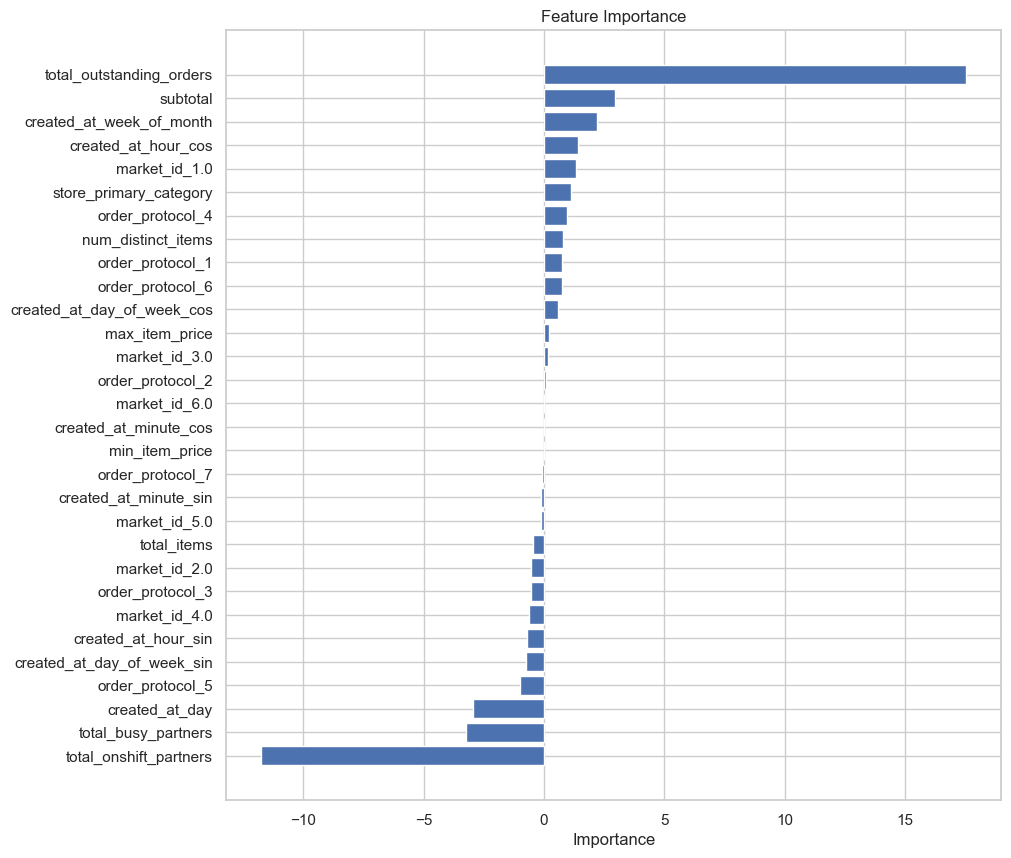

In [ ]:
importance = lr.coef_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()



In [26]:
lgbm = LGBMRegressor()
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_val)
print("LightGBM")
print("Mean Squared Error:", mean_squared_error(y_val, y_pred))
print("R2 Score:", r2_score(y_val, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_val, y_pred))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
LightGBM
Mean Squared Error: 219.5237756283164
R2 Score: 0.32279899236896115
Mean Absolute Error: 10.814171650427385


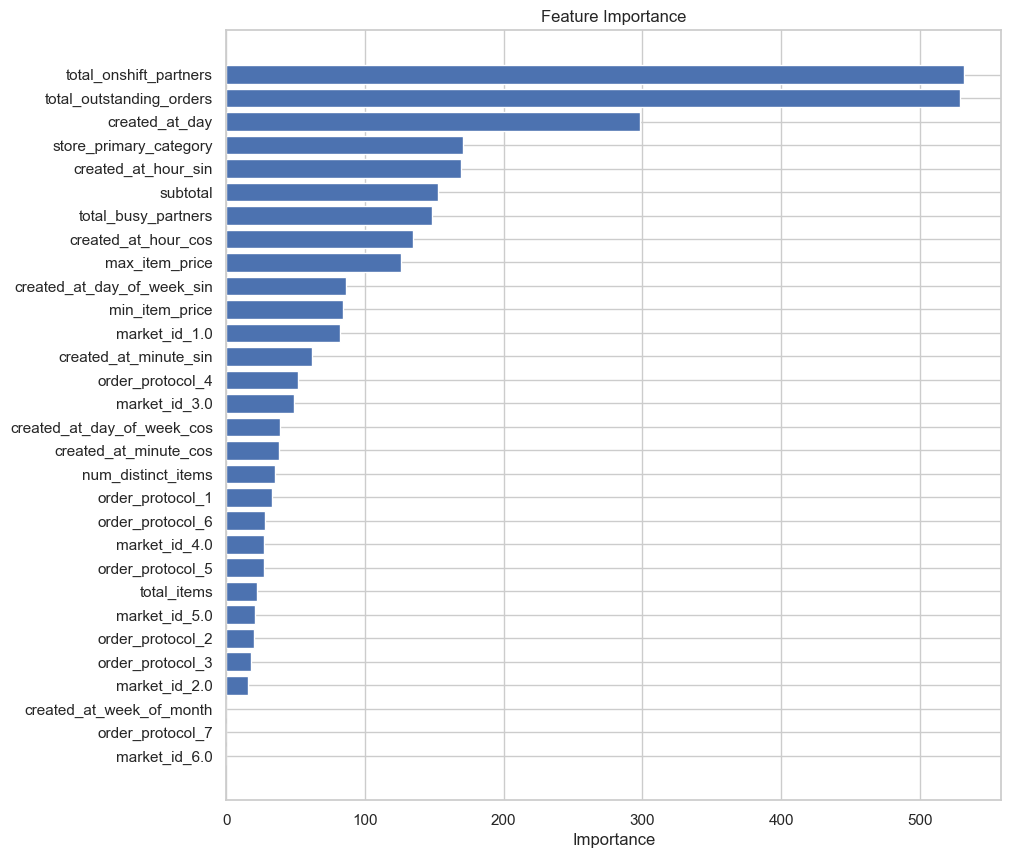

In [27]:
importance = lgbm.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [28]:
# set up optuna study
study = optuna.create_study(direction="minimize")
def objective(trial):
    # hyperparameter tuning
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20)
    }
    lgbm = LGBMRegressor(**params)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    return mse
# optimize hyperparameters
study.optimize(objective, n_trials=100)
# print best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)
# train final model with best hyperparameters


[I 2025-03-10 21:15:40,248] A new study created in memory with name: no-name-0b104d28-fc81-4ccc-a404-cc5b96495390


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:15:40,951] Trial 0 finished with value: 230.5686085709044 and parameters: {'learning_rate': 0.04229428611662271, 'num_leaves': 22, 'max_depth': 5, 'n_estimators': 137, 'min_child_samples': 12}. Best is trial 0 with value: 230.5686085709044.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:15:44,493] Trial 1 finished with value: 236.37473438642814 and parameters: {'learning_rate': 0.01105698944182072, 'num_leaves': 89, 'max_depth': 9, 'n_estimators': 181, 'min_child_samples': 5}. Best is trial 0 with value: 230.5686085709044.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:15:48,186] Trial 2 finished with value: 218.5013131446115 and parameters: {'learning_rate': 0.028630525229633753, 'num_leaves': 92, 'max_depth': 10, 'n_estimators': 181, 'min_child_samples': 17}. Best is trial 2 with value: 218.5013131446115.
[I 2025-03-10 21:15:48,368] Trial 3 finished with value: 254.4512790568143 and parameters: {'learning_rate': 0.07153386282372909, 'num_leaves': 96, 'max_depth': 3, 'n_estimators': 62, 'min_child_samples': 13}. Best is trial 2 with value: 218.5013131446115.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-03-10 21:15:49,783] Trial 4 finished with value: 218.62501701179409 and parameters: {'learning_rate': 0.08144135347877145, 'num_leaves': 98, 'max_depth': 12, 'n_estimators': 60, 'min_child_samples': 15}. Best is trial 2 with value: 218.5013131446115.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:15:51,405] Trial 5 finished with value: 216.90804463642215 and parameters: {'learning_rate': 0.09400630330386567, 'num_leaves': 43, 'max_depth': 10, 'n_estimators': 155, 'min_child_samples': 12}. Best is trial 5 with value: 216.90804463642215.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:15:54,907] Trial 6 finished with value: 223.0989637414738 and parameters: {'learning_rate': 0.020394084399491086, 'num_leaves': 88, 'max_depth': 8, 'n_estimators': 193, 'min_child_samples': 3}. Best is trial 5 with value: 216.90804463642215.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:15:55,869] Trial 7 finished with value: 219.1738392328787 and parameters: {'learning_rate': 0.09015956729843802, 'num_leaves': 53, 'max_depth': 8, 'n_estimators': 78, 'min_child_samples': 15}. Best is trial 5 with value: 216.90804463642215.
[I 2025-03-10 21:15:56,035] Trial 8 finished with value: 255.99756899605055 and parameters: {'learning_rate': 0.0819961752825288, 'num_leaves': 58, 'max_depth': 3, 'n_estimators': 50, 'min_child_samples': 2}. Best is trial 5 with value: 216.90804463642215.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-03-10 21:15:58,526] Trial 9 finished with value: 217.148996739166 and parameters: {'learning_rate': 0.056359766261936166, 'num_leaves': 100, 'max_depth': 12, 'n_estimators': 105, 'min_child_samples': 7}. Best is trial 5 with value: 216.90804463642215.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-03-10 21:15:59,651] Trial 10 finished with value: 217.6988427778786 and parameters: {'learning_rate': 0.09883172315802335, 'num_leaves': 36, 'max_depth': 6, 'n_estimators': 150, 'min_child_samples': 20}. Best is trial 5 with value: 216.90804463642215.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:16:01,464] Trial 11 finished with value: 218.36874562424128 and parameters: {'learning_rate': 0.05783945225555354, 'num_leaves': 70, 'max_depth': 12, 'n_estimators': 104, 'min_child_samples': 8}. Best is trial 5 with value: 216.90804463642215.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:16:02,647] Trial 12 finished with value: 220.57458050037752 and parameters: {'learning_rate': 0.06116378038499026, 'num_leaves': 43, 'max_depth': 11, 'n_estimators': 107, 'min_child_samples': 8}. Best is trial 5 with value: 216.90804463642215.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:16:05,214] Trial 13 finished with value: 217.9759896099461 and parameters: {'learning_rate': 0.04186003552378437, 'num_leaves': 71, 'max_depth': 10, 'n_estimators': 156, 'min_child_samples': 8}. Best is trial 5 with value: 216.90804463642215.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:16:07,108] Trial 14 finished with value: 217.32060690669192 and parameters: {'learning_rate': 0.0693276677258403, 'num_leaves': 71, 'max_depth': 10, 'n_estimators': 115, 'min_child_samples': 10}. Best is trial 5 with value: 216.90804463642215.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:16:07,939] Trial 15 finished with value: 228.67419710586515 and parameters: {'learning_rate': 0.04515861456825157, 'num_leaves': 33, 'max_depth': 12, 'n_estimators': 91, 'min_child_samples': 5}. Best is trial 5 with value: 216.90804463642215.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002643 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:16:09,369] Trial 16 finished with value: 217.52891376131166 and parameters: {'learning_rate': 0.09982257346566777, 'num_leaves': 47, 'max_depth': 11, 'n_estimators': 126, 'min_child_samples': 10}. Best is trial 5 with value: 216.90804463642215.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-03-10 21:16:11,710] Trial 17 finished with value: 216.6451721183057 and parameters: {'learning_rate': 0.07269492074872189, 'num_leaves': 82, 'max_depth': 7, 'n_estimators': 156, 'min_child_samples': 5}. Best is trial 17 with value: 216.6451721183057.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-03-10 21:16:13,478] Trial 18 finished with value: 218.61125466578875 and parameters: {'learning_rate': 0.08319133321763139, 'num_leaves': 80, 'max_depth': 6, 'n_estimators': 163, 'min_child_samples': 1}. Best is trial 17 with value: 216.6451721183057.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:16:15,145] Trial 19 finished with value: 217.7468089308133 and parameters: {'learning_rate': 0.07168672521279124, 'num_leaves': 62, 'max_depth': 7, 'n_estimators': 135, 'min_child_samples': 4}. Best is trial 17 with value: 216.6451721183057.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-03-10 21:16:16,051] Trial 20 finished with value: 220.50931563324488 and parameters: {'learning_rate': 0.09063181098077952, 'num_leaves': 26, 'max_depth': 5, 'n_estimators': 169, 'min_child_samples': 13}. Best is trial 17 with value: 216.6451721183057.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-10 21:16:18,580] Trial 21 finished with value: 217.20711640533682 and parameters: {'learning_rate': 0.051026266211493684, 'num_leaves': 80, 'max_depth': 9, 'n_estimators': 146, 'min_child_samples': 6}. Best is trial 17 with value: 216.6451721183057.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:16:20,711] Trial 22 finished with value: 216.6296981831689 and parameters: {'learning_rate': 0.06630060675722638, 'num_leaves': 78, 'max_depth': 11, 'n_estimators': 119, 'min_child_samples': 7}. Best is trial 22 with value: 216.6296981831689.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:16:22,956] Trial 23 finished with value: 216.37487389121551 and parameters: {'learning_rate': 0.06515852742711725, 'num_leaves': 83, 'max_depth': 9, 'n_estimators': 125, 'min_child_samples': 11}. Best is trial 23 with value: 216.37487389121551.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-03-10 21:16:24,894] Trial 24 finished with value: 218.02249112004588 and parameters: {'learning_rate': 0.0639269109054049, 'num_leaves': 81, 'max_depth': 7, 'n_estimators': 127, 'min_child_samples': 9}. Best is trial 23 with value: 216.37487389121551.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:16:26,991] Trial 25 finished with value: 216.9177229769101 and parameters: {'learning_rate': 0.07731805114404075, 'num_leaves': 84, 'max_depth': 9, 'n_estimators': 117, 'min_child_samples': 5}. Best is trial 23 with value: 216.37487389121551.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:16:29,108] Trial 26 finished with value: 217.01600067240733 and parameters: {'learning_rate': 0.06679968427920498, 'num_leaves': 75, 'max_depth': 8, 'n_estimators': 137, 'min_child_samples': 7}. Best is trial 23 with value: 216.37487389121551.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:16:30,454] Trial 27 finished with value: 222.03167246297562 and parameters: {'learning_rate': 0.05150925263064356, 'num_leaves': 65, 'max_depth': 11, 'n_estimators': 83, 'min_child_samples': 10}. Best is trial 23 with value: 216.37487389121551.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-03-10 21:16:31,519] Trial 28 finished with value: 221.84096667540146 and parameters: {'learning_rate': 0.07580517110798467, 'num_leaves': 86, 'max_depth': 6, 'n_estimators': 94, 'min_child_samples': 3}. Best is trial 23 with value: 216.37487389121551.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-03-10 21:16:32,073] Trial 29 finished with value: 239.55912634653396 and parameters: {'learning_rate': 0.037250445648979544, 'num_leaves': 77, 'max_depth': 4, 'n_estimators': 143, 'min_child_samples': 11}. Best is trial 23 with value: 216.37487389121551.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

[I 2025-03-10 21:16:34,264] Trial 30 finished with value: 218.05981655137992 and parameters: {'learning_rate': 0.06287609067362672, 'num_leaves': 94, 'max_depth': 7, 'n_estimators': 131, 'min_child_samples': 6}. Best is trial 23 with value: 216.37487389121551.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46

[I 2025-03-10 21:16:36,353] Trial 31 finished with value: 216.3382282997891 and parameters: {'learning_rate': 0.08956727611320037, 'num_leaves': 54, 'max_depth': 10, 'n_estimators': 171, 'min_child_samples': 12}. Best is trial 31 with value: 216.3382282997891.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:16:38,463] Trial 32 finished with value: 215.9043030503911 and parameters: {'learning_rate': 0.0881080210549146, 'num_leaves': 56, 'max_depth': 9, 'n_estimators': 172, 'min_child_samples': 14}. Best is trial 32 with value: 215.9043030503911.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:16:40,742] Trial 33 finished with value: 215.83467035506658 and parameters: {'learning_rate': 0.08714549663461063, 'num_leaves': 53, 'max_depth': 9, 'n_estimators': 197, 'min_child_samples': 15}. Best is trial 33 with value: 215.83467035506658.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:16:43,054] Trial 34 finished with value: 215.52894732463525 and parameters: {'learning_rate': 0.08775250723760475, 'num_leaves': 53, 'max_depth': 9, 'n_estimators': 200, 'min_child_samples': 15}. Best is trial 34 with value: 215.52894732463525.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:16:45,404] Trial 35 finished with value: 216.33656101173875 and parameters: {'learning_rate': 0.08661894045105606, 'num_leaves': 53, 'max_depth': 10, 'n_estimators': 198, 'min_child_samples': 16}. Best is trial 34 with value: 215.52894732463525.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:16:47,553] Trial 36 finished with value: 216.23658002763887 and parameters: {'learning_rate': 0.08610684602814933, 'num_leaves': 49, 'max_depth': 9, 'n_estimators': 199, 'min_child_samples': 17}. Best is trial 34 with value: 215.52894732463525.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:16:49,521] Trial 37 finished with value: 216.3624172294172 and parameters: {'learning_rate': 0.09547710882209642, 'num_leaves': 48, 'max_depth': 9, 'n_estimators': 185, 'min_child_samples': 18}. Best is trial 34 with value: 215.52894732463525.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002340 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:16:51,145] Trial 38 finished with value: 217.12385356677515 and parameters: {'learning_rate': 0.0788290906933685, 'num_leaves': 38, 'max_depth': 8, 'n_estimators': 187, 'min_child_samples': 14}. Best is trial 34 with value: 215.52894732463525.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:16:53,623] Trial 39 finished with value: 215.80234131443024 and parameters: {'learning_rate': 0.08589419456247549, 'num_leaves': 58, 'max_depth': 9, 'n_estimators': 200, 'min_child_samples': 17}. Best is trial 34 with value: 215.52894732463525.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:16:55,760] Trial 40 finished with value: 216.0143214721454 and parameters: {'learning_rate': 0.09282985853474404, 'num_leaves': 59, 'max_depth': 8, 'n_estimators': 176, 'min_child_samples': 19}. Best is trial 34 with value: 215.52894732463525.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:16:57,928] Trial 41 finished with value: 215.57631600735104 and parameters: {'learning_rate': 0.09428398432027059, 'num_leaves': 59, 'max_depth': 8, 'n_estimators': 177, 'min_child_samples': 19}. Best is trial 34 with value: 215.52894732463525.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:17:00,443] Trial 42 finished with value: 215.6231115636317 and parameters: {'learning_rate': 0.08636525200110556, 'num_leaves': 65, 'max_depth': 8, 'n_estimators': 191, 'min_child_samples': 16}. Best is trial 34 with value: 215.52894732463525.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-03-10 21:17:02,906] Trial 43 finished with value: 216.13731649993102 and parameters: {'learning_rate': 0.09592715221559754, 'num_leaves': 64, 'max_depth': 8, 'n_estimators': 192, 'min_child_samples': 17}. Best is trial 34 with value: 215.52894732463525.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-03-10 21:17:05,327] Trial 44 finished with value: 215.21554451376028 and parameters: {'learning_rate': 0.08369104653937981, 'num_leaves': 66, 'max_depth': 8, 'n_estimators': 180, 'min_child_samples': 20}. Best is trial 44 with value: 215.21554451376028.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:17:07,952] Trial 45 finished with value: 239.48211824307285 and parameters: {'learning_rate': 0.01091745271523293, 'num_leaves': 66, 'max_depth': 8, 'n_estimators': 181, 'min_child_samples': 20}. Best is trial 44 with value: 215.21554451376028.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-03-10 21:17:10,288] Trial 46 finished with value: 216.04657548757976 and parameters: {'learning_rate': 0.08369440786577481, 'num_leaves': 69, 'max_depth': 7, 'n_estimators': 186, 'min_child_samples': 19}. Best is trial 44 with value: 215.21554451376028.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-03-10 21:17:12,651] Trial 47 finished with value: 215.91352997104022 and parameters: {'learning_rate': 0.09380734678928031, 'num_leaves': 61, 'max_depth': 8, 'n_estimators': 191, 'min_child_samples': 18}. Best is trial 44 with value: 215.21554451376028.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-03-10 21:17:14,355] Trial 48 finished with value: 217.53213617616288 and parameters: {'learning_rate': 0.07943641694637053, 'num_leaves': 58, 'max_depth': 6, 'n_estimators': 179, 'min_child_samples': 16}. Best is trial 44 with value: 215.21554451376028.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211,

[I 2025-03-10 21:17:16,910] Trial 49 finished with value: 226.9264991032848 and parameters: {'learning_rate': 0.019648483111937926, 'num_leaves': 67, 'max_depth': 10, 'n_estimators': 162, 'min_child_samples': 19}. Best is trial 44 with value: 215.21554451376028.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:17:18,753] Trial 50 finished with value: 217.12813626961758 and parameters: {'learning_rate': 0.0753973036474375, 'num_leaves': 44, 'max_depth': 7, 'n_estimators': 200, 'min_child_samples': 18}. Best is trial 44 with value: 215.21554451376028.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:17:20,875] Trial 51 finished with value: 216.31094890949447 and parameters: {'learning_rate': 0.08440512815355317, 'num_leaves': 50, 'max_depth': 9, 'n_estimators': 192, 'min_child_samples': 16}. Best is trial 44 with value: 215.21554451376028.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:17:23,636] Trial 52 finished with value: 215.45933022575647 and parameters: {'learning_rate': 0.09838219538351002, 'num_leaves': 73, 'max_depth': 9, 'n_estimators': 183, 'min_child_samples': 20}. Best is trial 44 with value: 215.21554451376028.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-03-10 21:17:26,053] Trial 53 finished with value: 215.93854519173 and parameters: {'learning_rate': 0.09816389633477877, 'num_leaves': 74, 'max_depth': 8, 'n_estimators': 164, 'min_child_samples': 20}. Best is trial 44 with value: 215.21554451376028.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:17:28,392] Trial 54 finished with value: 215.58037027059302 and parameters: {'learning_rate': 0.09956250325103794, 'num_leaves': 62, 'max_depth': 9, 'n_estimators': 177, 'min_child_samples': 20}. Best is trial 44 with value: 215.21554451376028.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:17:31,102] Trial 55 finished with value: 215.33676963523203 and parameters: {'learning_rate': 0.09186469690225225, 'num_leaves': 72, 'max_depth': 10, 'n_estimators': 176, 'min_child_samples': 20}. Best is trial 44 with value: 215.21554451376028.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:17:33,857] Trial 56 finished with value: 215.5011010326668 and parameters: {'learning_rate': 0.09259906203982114, 'num_leaves': 73, 'max_depth': 10, 'n_estimators': 176, 'min_child_samples': 20}. Best is trial 44 with value: 215.21554451376028.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:17:36,503] Trial 57 finished with value: 215.2398532564746 and parameters: {'learning_rate': 0.09138396048176003, 'num_leaves': 73, 'max_depth': 10, 'n_estimators': 168, 'min_child_samples': 19}. Best is trial 44 with value: 215.21554451376028.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:17:39,133] Trial 58 finished with value: 215.40291381438774 and parameters: {'learning_rate': 0.09102878371950222, 'num_leaves': 72, 'max_depth': 11, 'n_estimators': 166, 'min_child_samples': 20}. Best is trial 44 with value: 215.21554451376028.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:17:41,648] Trial 59 finished with value: 215.86733928079187 and parameters: {'learning_rate': 0.09168487753511959, 'num_leaves': 71, 'max_depth': 11, 'n_estimators': 159, 'min_child_samples': 20}. Best is trial 44 with value: 215.21554451376028.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:17:44,670] Trial 60 finished with value: 215.4433096651897 and parameters: {'learning_rate': 0.08107991268393722, 'num_leaves': 90, 'max_depth': 12, 'n_estimators': 152, 'min_child_samples': 18}. Best is trial 44 with value: 215.21554451376028.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:17:47,707] Trial 61 finished with value: 214.89201016494331 and parameters: {'learning_rate': 0.08112256651349986, 'num_leaves': 90, 'max_depth': 12, 'n_estimators': 151, 'min_child_samples': 19}. Best is trial 61 with value: 214.89201016494331.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:17:50,711] Trial 62 finished with value: 215.18565064746585 and parameters: {'learning_rate': 0.08115133220867637, 'num_leaves': 89, 'max_depth': 12, 'n_estimators': 152, 'min_child_samples': 18}. Best is trial 61 with value: 214.89201016494331.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:17:53,744] Trial 63 finished with value: 215.17236743115558 and parameters: {'learning_rate': 0.07941108066698939, 'num_leaves': 90, 'max_depth': 12, 'n_estimators': 151, 'min_child_samples': 18}. Best is trial 61 with value: 214.89201016494331.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:17:56,875] Trial 64 finished with value: 215.60756657082962 and parameters: {'learning_rate': 0.07367911797146207, 'num_leaves': 98, 'max_depth': 12, 'n_estimators': 144, 'min_child_samples': 19}. Best is trial 61 with value: 214.89201016494331.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:18:00,228] Trial 65 finished with value: 214.99667819069478 and parameters: {'learning_rate': 0.06966394801422622, 'num_leaves': 92, 'max_depth': 11, 'n_estimators': 167, 'min_child_samples': 18}. Best is trial 61 with value: 214.89201016494331.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:18:03,308] Trial 66 finished with value: 215.66888956921042 and parameters: {'learning_rate': 0.06871971297010174, 'num_leaves': 92, 'max_depth': 12, 'n_estimators': 150, 'min_child_samples': 18}. Best is trial 61 with value: 214.89201016494331.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:18:06,321] Trial 67 finished with value: 215.0059925552878 and parameters: {'learning_rate': 0.08140054763246701, 'num_leaves': 87, 'max_depth': 11, 'n_estimators': 158, 'min_child_samples': 19}. Best is trial 61 with value: 214.89201016494331.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:18:09,044] Trial 68 finished with value: 215.60604007811796 and parameters: {'learning_rate': 0.08050770087468781, 'num_leaves': 87, 'max_depth': 12, 'n_estimators': 139, 'min_child_samples': 17}. Best is trial 61 with value: 214.89201016494331.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:18:12,446] Trial 69 finished with value: 215.05591342227336 and parameters: {'learning_rate': 0.0774041879493627, 'num_leaves': 100, 'max_depth': 11, 'n_estimators': 158, 'min_child_samples': 19}. Best is trial 61 with value: 214.89201016494331.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:18:15,840] Trial 70 finished with value: 214.84368344555986 and parameters: {'learning_rate': 0.069986809582495, 'num_leaves': 96, 'max_depth': 11, 'n_estimators': 158, 'min_child_samples': 18}. Best is trial 70 with value: 214.84368344555986.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:18:19,087] Trial 71 finished with value: 215.19798241546803 and parameters: {'learning_rate': 0.07097193759663518, 'num_leaves': 94, 'max_depth': 11, 'n_estimators': 157, 'min_child_samples': 18}. Best is trial 70 with value: 214.84368344555986.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:18:22,541] Trial 72 finished with value: 215.20690146220278 and parameters: {'learning_rate': 0.05981723627866931, 'num_leaves': 100, 'max_depth': 11, 'n_estimators': 156, 'min_child_samples': 18}. Best is trial 70 with value: 214.84368344555986.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002424 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:18:25,575] Trial 73 finished with value: 215.67461633874947 and parameters: {'learning_rate': 0.07053434846822805, 'num_leaves': 95, 'max_depth': 11, 'n_estimators': 147, 'min_child_samples': 17}. Best is trial 70 with value: 214.84368344555986.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:18:28,828] Trial 74 finished with value: 215.44835136732343 and parameters: {'learning_rate': 0.0739166870614354, 'num_leaves': 92, 'max_depth': 12, 'n_estimators': 159, 'min_child_samples': 18}. Best is trial 70 with value: 214.84368344555986.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:18:32,070] Trial 75 finished with value: 214.7729832513313 and parameters: {'learning_rate': 0.07752425203437846, 'num_leaves': 97, 'max_depth': 11, 'n_estimators': 153, 'min_child_samples': 19}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:18:35,398] Trial 76 finished with value: 215.30654608005236 and parameters: {'learning_rate': 0.07677727210006226, 'num_leaves': 97, 'max_depth': 12, 'n_estimators': 152, 'min_child_samples': 19}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:18:38,254] Trial 77 finished with value: 215.48142768343618 and parameters: {'learning_rate': 0.06828213836464121, 'num_leaves': 89, 'max_depth': 11, 'n_estimators': 143, 'min_child_samples': 17}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:18:40,927] Trial 78 finished with value: 215.5540757004035 and parameters: {'learning_rate': 0.0815738940074614, 'num_leaves': 85, 'max_depth': 12, 'n_estimators': 139, 'min_child_samples': 19}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:18:44,388] Trial 79 finished with value: 214.88795572775285 and parameters: {'learning_rate': 0.07679428843551597, 'num_leaves': 99, 'max_depth': 11, 'n_estimators': 161, 'min_child_samples': 16}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:18:47,861] Trial 80 finished with value: 214.78928100766797 and parameters: {'learning_rate': 0.07855778194275859, 'num_leaves': 99, 'max_depth': 11, 'n_estimators': 161, 'min_child_samples': 16}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:18:51,377] Trial 81 finished with value: 215.59144449896428 and parameters: {'learning_rate': 0.07801588474464419, 'num_leaves': 99, 'max_depth': 11, 'n_estimators': 162, 'min_child_samples': 14}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:18:54,902] Trial 82 finished with value: 215.10841260569143 and parameters: {'learning_rate': 0.07530094280189627, 'num_leaves': 95, 'max_depth': 11, 'n_estimators': 171, 'min_child_samples': 15}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:18:58,457] Trial 83 finished with value: 215.07943930277116 and parameters: {'learning_rate': 0.07475642109858543, 'num_leaves': 96, 'max_depth': 11, 'n_estimators': 172, 'min_child_samples': 15}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:19:01,968] Trial 84 finished with value: 215.1300825144019 and parameters: {'learning_rate': 0.06613443326526804, 'num_leaves': 97, 'max_depth': 11, 'n_estimators': 166, 'min_child_samples': 16}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:19:05,699] Trial 85 finished with value: 215.07264099192528 and parameters: {'learning_rate': 0.07154903428676555, 'num_leaves': 100, 'max_depth': 11, 'n_estimators': 173, 'min_child_samples': 13}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:19:08,849] Trial 86 finished with value: 214.99549386858422 and parameters: {'learning_rate': 0.07211652533578002, 'num_leaves': 92, 'max_depth': 10, 'n_estimators': 162, 'min_child_samples': 13}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:19:11,983] Trial 87 finished with value: 215.5350919200831 and parameters: {'learning_rate': 0.06351086667702645, 'num_leaves': 92, 'max_depth': 10, 'n_estimators': 159, 'min_child_samples': 12}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:19:14,909] Trial 88 finished with value: 215.18718691260185 and parameters: {'learning_rate': 0.07793991449628725, 'num_leaves': 93, 'max_depth': 10, 'n_estimators': 148, 'min_child_samples': 13}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:19:18,086] Trial 89 finished with value: 215.4046600562764 and parameters: {'learning_rate': 0.0725786388382293, 'num_leaves': 87, 'max_depth': 11, 'n_estimators': 168, 'min_child_samples': 17}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:19:21,454] Trial 90 finished with value: 215.83592240719338 and parameters: {'learning_rate': 0.06128591606881499, 'num_leaves': 98, 'max_depth': 10, 'n_estimators': 162, 'min_child_samples': 14}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:19:24,858] Trial 91 finished with value: 215.69582155948987 and parameters: {'learning_rate': 0.05519601858416942, 'num_leaves': 100, 'max_depth': 11, 'n_estimators': 155, 'min_child_samples': 13}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:19:28,287] Trial 92 finished with value: 215.32066337174126 and parameters: {'learning_rate': 0.06957983739326777, 'num_leaves': 96, 'max_depth': 11, 'n_estimators': 165, 'min_child_samples': 9}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:19:32,020] Trial 93 finished with value: 214.93033215285016 and parameters: {'learning_rate': 0.07220027983524234, 'num_leaves': 100, 'max_depth': 11, 'n_estimators': 173, 'min_child_samples': 11}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:19:35,233] Trial 94 finished with value: 215.1666008771464 and parameters: {'learning_rate': 0.07660051678881942, 'num_leaves': 94, 'max_depth': 10, 'n_estimators': 161, 'min_child_samples': 19}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:19:38,307] Trial 95 finished with value: 215.3600909141273 and parameters: {'learning_rate': 0.08447642630393175, 'num_leaves': 91, 'max_depth': 11, 'n_estimators': 156, 'min_child_samples': 11}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:19:41,908] Trial 96 finished with value: 215.1861592386826 and parameters: {'learning_rate': 0.06779855718016263, 'num_leaves': 97, 'max_depth': 12, 'n_estimators': 168, 'min_child_samples': 16}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:19:44,755] Trial 97 finished with value: 215.5819560456533 and parameters: {'learning_rate': 0.07272908720786593, 'num_leaves': 84, 'max_depth': 11, 'n_estimators': 154, 'min_child_samples': 9}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 30
[LightGBM] [Info] Start training from score 46.935038


[I 2025-03-10 21:19:46,250] Trial 98 finished with value: 217.69328020353836 and parameters: {'learning_rate': 0.08885259257413922, 'num_leaves': 98, 'max_depth': 12, 'n_estimators': 64, 'min_child_samples': 10}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-03-10 21:19:49,188] Trial 99 finished with value: 215.24989872877293 and parameters: {'learning_rate': 0.08249119177884487, 'num_leaves': 94, 'max_depth': 10, 'n_estimators': 148, 'min_child_samples': 19}. Best is trial 75 with value: 214.7729832513313.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Hyperparameters: {'learning_rate': 0.07752425203437846, 'num_leaves': 97, 'max_depth': 11, 'n_estimators': 153, 'min_child_samples': 19}


Best Hyperparameters: {'learning_rate': 0.07752425203437846, 'num_leaves': 97, 'max_depth': 11, 'n_estimators': 153, 'min_child_samples': 19}

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1822
[LightGBM] [Info] Number of data points in the train set: 124211, number of used features: 29
[LightGBM] [Info] Start training from score 46.935038
Validation Mean Squared Error: 214.7729832513313
Validation R2 Score: 0.33745454106992456


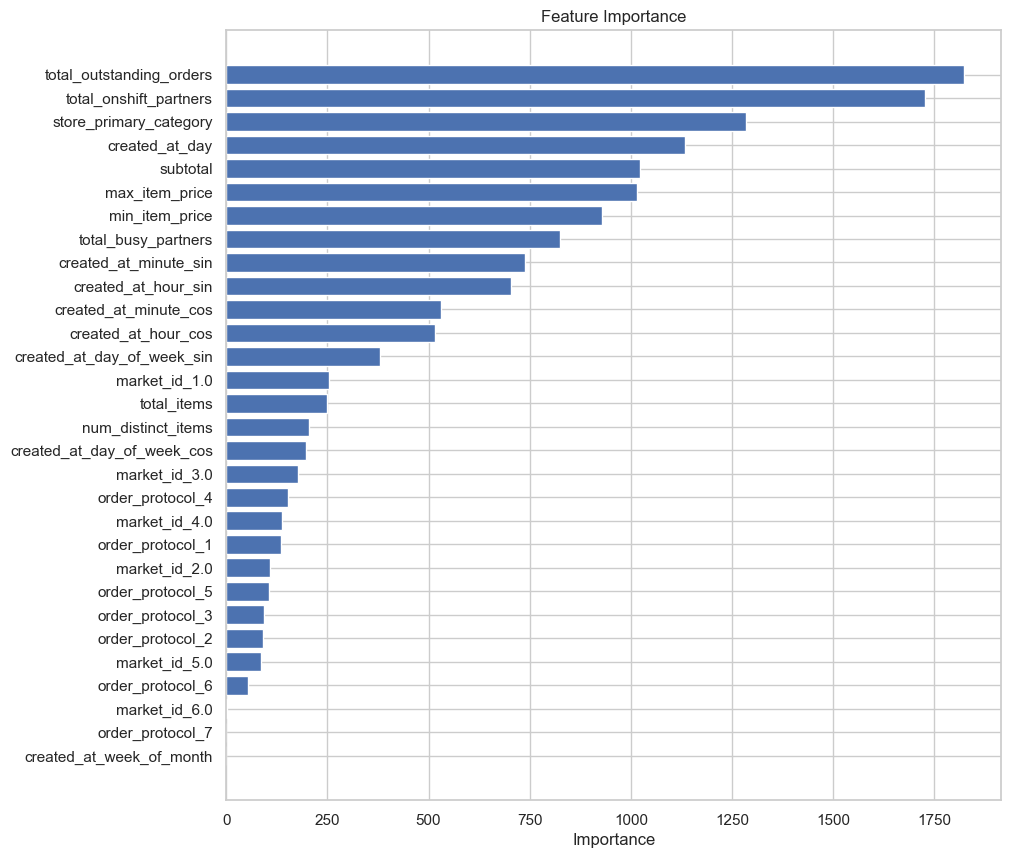

In [30]:
lgbm = LGBMRegressor(**best_params)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_val)
print("Validation Mean Squared Error:", mean_squared_error(y_val, y_pred))
print("Validation R2 Score:", r2_score(y_val, y_pred))
importance = lgbm.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()